In [55]:
%matplotlib inline


`torch.nn` 이 *실제로* 무엇인가요?
===============================
저자: Jeremy Howard, `fast.ai <https://www.fast.ai>`_.

도움: Rachel Thomas, Francisco Ingham.

번역: `남상호 <https://github.com/namdori61>`_



이 튜토리얼을 스크립트가 아닌 노트북으로 실행하기를 권장합니다. 노트북 (.ipynb) 파일을 다운 받으시려면,
페이지 상단에 있는 링크를 클릭해주세요.

PyTorch 는 여러분이 신경망(neural network)를 생성하고 학습시키는 것을 도와주기 위해서
`torch.nn <https://pytorch.org/docs/stable/nn.html>`_ ,
`torch.optim <https://pytorch.org/docs/stable/optim.html>`_ ,
`Dataset <https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset>`_ ,
그리고 `DataLoader <https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader>`_
와 같은 잘 디자인된 모듈과 클래스들을 제공합니다.
이들의 성능을 최대한 활용하고 여러분의 문제에 맞게 커스터마이즈하기 위해서,
정확히 이들이 어떤 작업을 수행하는지 이해할 필요가 있습니다.
이해를 증진하기 위해서, 우리는 먼저 이들 모델들로 부터 아무 피쳐도 사용하지 않고
MNIST 데이터셋에 대해 기초적인 신경망을 학습시킬 것입니다;
우리는 처음에는 가장 기초적인 PyTorch 텐서(tensor) 기능만을 사용할 것입니다.
그리고나서 우리는 점차적으로 ``torch.nn``, ``torch.optim``, ``Dataset``, 또는
``DataLoader`` 로부터 한번에 하나씩 피쳐를 추가하면서, 정확히 각 부분이 어떤 일을 하는지 그리고
이것이 어떻게 코드를 더 정확하고 유연하게 만드는지 보여줄 것입니다.

**이 튜토리얼은 여러분이 이미 PyTorch를 설치하였고, 그리고 텐서 연산의 기초에 대해 익숙하다고 가정합니다.**
(만약 여러분이 Numpy 배열(array) 연산에 익숙하다면, 여기에서 사용되는 PyTorch 텐서 연산도
거의 동일하다는 것을 알게 될 것입니다).

MNIST 데이터 준비
----------------

우리는 손으로 쓴 숫자(0에서 9 사이)의 흑백 이미지로 구성된 클래식
`MNIST <http://deeplearning.net/data/mnist/>`_ 데이터셋을 사용할 것 입니다.

우리는 경로 설정을 담당하는 (Python3 표준 라이브러리의 일부인)
`pathlib <https://docs.python.org/3/library/pathlib.html>`_ 을 사용할 것이고,
`requests <http://docs.python-requests.org/en/master/>`_ 를 이용하여
데이터셋을 다운로드 할 것입니다. 우리는 모듈을 사용할 때만 임포트(import) 할 것이므로,
여러분은 매 포인트마다 정확히 어떤 것이 사용되는지 확인할 수 있습니다.



In [56]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

이 데이터셋은 numpy 배열 포맷이고, 데이터를 직렬화하기 위한
python 전용 포맷 pickle 을 이용하여 저장되어 있습니다.



In [57]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

각 이미지는 28 x 28 형태 이고, 784 (=28x28) 크기를 가진 하나의 행으로 저장되어 있습니다.
하나를 살펴 봅시다; 먼저 우리는 이 이미지를 2d로 재구성해야 합니다.



(50000, 784)


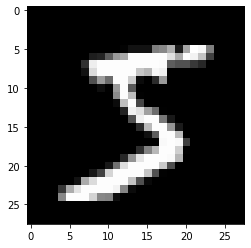

In [58]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch는 numpy 배열 보다는 ``torch.tensor`` 를 사용하므로, 우리는 데이터를 변환해야 합니다.



In [59]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


torch.nn 없이 밑바닥부터 신경망 만들기
---------------------------------------------

PyTorch 텐서 연산만으로 첫 모델을 만들어봅시다.
여러분이 신경망의 기초에 대해서 이미 익숙하다고 가정합니다.
(만약 익숙하지 않다면 `course.fast.ai <https://course.fast.ai>`_ 에서 학습할 수 있습니다).

PyTorch는 랜덤 또는 0으로만 이루어진 텐서를 생성하는 메서드를 제공하고,
우리는 간단한 선형 모델의 가중치(weights)와 절편(bias)을 생성하기 위해서 이것을 사용할 것입니다.
이들은 일반적인 텐서에 매우 특별한 한 가지가 추가된 것입니다: 우리는 PyTorch에게 이들이
기울기(gradient)가 필요하다고 알려줍니다.
이를 통해 PyTorch는 텐서에 행해지는 모든 연산을 기록하게 하고,
따라서 *자동적으로* 역전파(back-propagation) 동안에 기울기를 계산할 수 있습니다!

가중치에 대해서는 ``requires_grad`` 를 초기화(initialization) **다음에** 설정합니다,
왜냐하면 우리는 해당 단계가 기울기에 포함되는 것을 원치 않기 때문입니다.
(PyTorch에서 ``_`` 다음에 오는 메서드 이름은 연산이 인플레이스(in-place)로 수행되는 것을 의미합니다.)

<div class="alert alert-info"><h4>Note</h4><p>`Xavier initialisation <http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf>`_
   기법을 이용하여 가중치를 초기화 합니다. (1/sqrt(n)을 곱해주는 것을 통해서 초기화).</p></div>



#### Xavier 초기화 방법

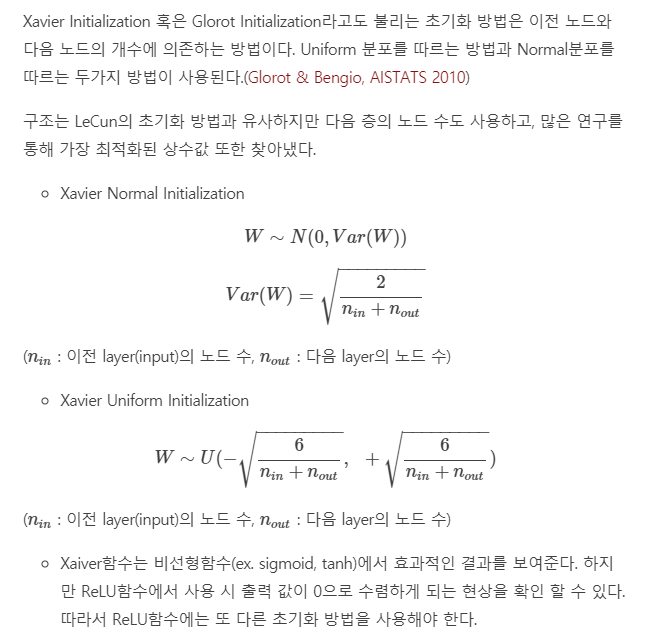
https://reniew.github.io/13/

In [60]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [61]:
bias

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

PyTorch의 기울기를 자동으로 계산해주는 기능 덕분에, Python 표준 함수
(또는 호출 가능한 객체)를 모델로 사용할 수 있습니다!
그러므로 간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드캐스트(broadcast)
덧셈을 사용하여 보겠습니다. 또한, 우리는 활성화 함수(activation function)가 필요하므로,
`log_softmax` 를 구현하고 사용할 것입니다.
PyTorch에서 많은 사전 구현된 손실 함수(loss function), 활성화 함수들이 제공되지만,
일반적인 python을 사용하여 자신만의 함수를 쉽게 작성할 수 있음을 기억해주세요.
PyTorch는 심지어 여러분의 함수를 위해서 빠른 GPU 또는 벡터화된 CPU 코드를 만들어줄 것입니다.



In [62]:
# exp 취했다가 log 취한 거여서 위와 같이 빼기 형태로 나옴
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
# .sum(-1) : -1 차원으로 합
# .unsqueeze(-1) : -1차원에 1인 차원을 추가

def model(xb):
    return log_softmax(xb @ weights + bias)

#### squeeze : 크기가 1인 차원을 제거한다 

In [63]:
x = torch.Tensor([[1],[2],[3]])
print(x.shape)
print(x.squeeze())
print(x.squeeze(0)) # 0번째 차원은 차원의 크기가 1이 아니어서 제거가 안됨.
print(x.squeeze(-1))

torch.Size([3, 1])
tensor([1., 2., 3.])
tensor([[1.],
        [2.],
        [3.]])
tensor([1., 2., 3.])


#### 스칼라곱(scalar product, dot product)
\- \* : multiplication

In [64]:
x = torch.Tensor([1, 2, 3])
y = x + 1
print(x @ y)
print(x @ y.unsqueeze(-1))
print(x * y)
print(x * y.unsqueeze(-1))
print(x.dot(y)) 

tensor(20.)
tensor([20.])
tensor([ 2.,  6., 12.])
tensor([[ 2.,  4.,  6.],
        [ 3.,  6.,  9.],
        [ 4.,  8., 12.]])
tensor(20.)


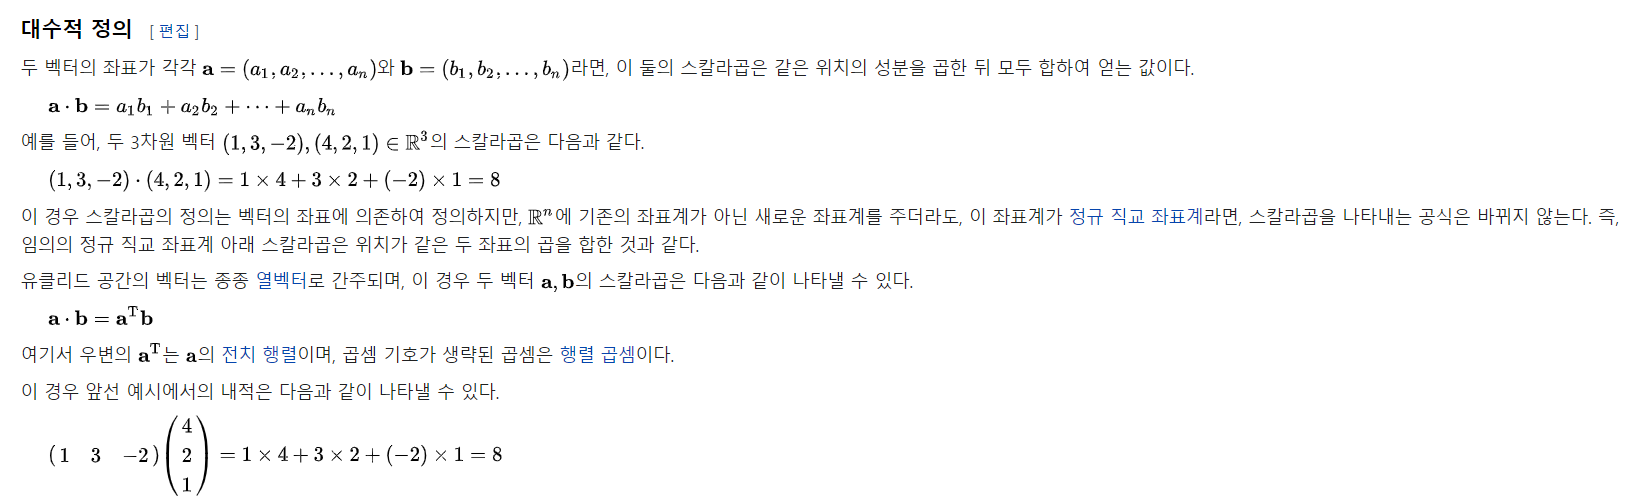
https://ko.wikipedia.org/wiki/%EC%8A%A4%EC%B9%BC%EB%9D%BC%EA%B3%B1

위에서, ``@`` 기호는 점곱(dot product) 연산을 나타냅니다.
우리는 하나의 배치(batch) 데이터(이 경우에는 64개의 이미지들)에 대하여 함수를 호출할 것입니다.
이것은 하나의 *포워드 전달(forward pass)* 입니다. 이 단계에서 우리는 무작위(random) 가중치로
시작했기 때문에 우리의 예측이 무작위 예측보다 전혀 나은 점이 없을 것입니다.



In [65]:
bs = 64  # 배치 사이즈

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.6840, -1.6937, -2.3771, -2.2277, -2.4007, -2.3359, -2.4867, -2.0859,
        -2.7174, -2.4479], grad_fn=<SelectBackward>) torch.Size([64, 10])


여러분이 보시듯이, ``preds`` 텐서(tensor)는 텐서 값 외에도, 또한
기울기 함수(gradient function)를 담고 있습니다.
우리는 나중에 이것을 역전파(backpropagation)를 위해 사용할 것입니다.
이제 손실함수(loss function)로 사용하기 위한 음의 로그 우도(negative log-likelihood)를
구현합시다. (다시 말하지만, 우리는 표준 Python을 사용할 수 있습니다.):



def nll(input, target):<br>
return -input[range(target.shape[0]), target].mean()

의미 : <br>
첫번째 dim : 데이터 크기만큼의 인덱싱<br>
두번째 dim : target(정답)<br>
-input[range(target.shape[0]), target] 의 의미는<br>
만약 첫번째 데이터의 정답이 13이라면, 첫번째 데이터의 13에 대한 log likelihood 

In [72]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

우리의 무작위 모델에 대한 손실을 점검해봅시다, 그럼으로써 우리는 나중에 역전파 이후에 개선이 있는지
확인할 수 있습니다.



또한, 우리 모델의 정확도(accuracy)를 계산하기 위한 함수를 구현합시다.
매 예측마다, 만약 가장 큰 값의 인덱스가 목표값(target value)과 동일하다면,
그 예측은 올바른 것입니다.



In [73]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

우리의 무작위 모델의 정확도를 점검해 봅시다, 그럼으로써 손실이 개선됨에 따라서 정확도가 개선되는지
확인할 수 있습니다.



이제 우리는 훈련 루프(training loop)를 실행할 수 있습니다. 매 반복마다, 우리는 다음을 수행할 것입니다:

- 데이터의 미니배치를 선택 (``bs`` 사이즈)
- 모델을 이용하여 예측 수행
- 손실 계산
- ``loss.backward()`` 를 이용하여 모델의 기울기 업데이트, 이 경우에는, ``weights`` 와 ``bias``.

이제 우리는 이 기울기들을 이용하여 가중치와 절편을 업데이트 합니다.
우리는 이것을 ``torch.no_grad()`` 컨텍스트 매니져(context manager) 내에서 실행합니다,
왜냐하면 이러한 실행이 다음 기울기의 계산에 기록되지 않기를 원하기 때문입니다.
PyTorch의 자동 기울기(Autograd)가 어떻게 연산을 기록하는지
`여기 <https://pytorch.org/docs/stable/notes/autograd.html>`_ 에서 더 알아볼 수 있습니다.

우리는 그러고나서 기울기를 0으로 설정합니다, 그럼으로써 다음 루프(loop)에 준비하게 됩니다.
그렇지 않으면, 우리의 기울기들은 일어난 모든 연산의 누적 집계를 기록하게 되버립니다.
(즉, ``loss.backward()`` 가 이미 저장된 것을 대체하기보단, 기존 값에 기울기를 *더하게* 됩니다).

.. tip:: 여러분들은 PyTorch 코드에 대하여 표준 python 디버거(debugger)를 사용할 수 있으므로,
   매 단계마다 다양한 변수 값을 점검할 수 있습니다.
   아래에서 ``set_trace()`` 를 주석 해제하여 사용해보세요.




In [74]:
from IPython.core.debugger import set_trace

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에포크(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
#         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

이제 다 됐습니다: 우리는 제일 간단한 신경망(neural network)의 모든 것을 밑바닥부터 생성하고
훈련하였습니다! (이번에는 은닉층(hidden layer)이 없기 때문에,
로지스틱 회귀(logistic regression)입니다).

이제 손실과 정확도를 이전 값들과 비교하면서 확인해봅시다.
우리는 손실은 감소하고, 정확도는 증가하기를 기대할 것이고, 그들은 아래와 같습니다.



In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0837, grad_fn=<NegBackward>) tensor(1.)


torch.nn.functional 사용하기
------------------------------

이제 우리는 코드를 리팩토링(refactoring) 하겠습니다, 그럼으로써 이전과 동일하지만,
PyTorch의 ``nn`` 클래스의 장점을 활용하여 더 간결하고 유연하게 만들 것입니다.
지금부터 매 단계에서, 우리는 코드를 더 짧고, 이해하기 쉽고, 유연하게 만들어야 합니다.

처음이면서 우리의 코드를 짧게 만들기 가장 쉬운 단계는 직접 작성한 활성화, 손실 함수를
``torch.nn.functional`` 의 함수로 대체하는 것입니다
(관례에 따라, 일반적으로 ``F`` 네임스페이스(namespace)를 통해 임포트(import) 합니다).
이 모듈에는 ``torch.nn`` 라이브러리의 모든 함수가 포함되어 있습니다
(라이브러리의 다른 부분에는 클래스가 포함되어 있습니다.)
다양한 손실 및 활성화 함수 뿐만 아니라, 풀링(pooling) 함수와 같이 신경망을 만드는데
편리한 몇 가지 함수도 여기에서 찾을 수 있습니다.
(컨볼루션(convolution) 연산, 선형(linear) 레이어, 등을 수행하는 함수도 있지만,
앞으로 보시겠지만 일반적으로 라이브러리의 다른 부분을 사용하여 더 잘 처리 할 수 있습니다.)

만약 여러분들이 음의 로그 우도 손실과 로그 소프트맥스 (log softmax) 활성화 함수를 사용하는 경우,
Pytorch는 이 둘을 결합하는 단일 함수인 ``F.cross_entropy`` 를 제공합니다.
따라서 모델에서 활성화 함수를 제거할 수도 있습니다.



In [16]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

더이상 ``model`` 함수에서 ``log_softmax`` 를 호출하지 않고 있습니다.
손실과 정확도과 이전과 동일한지 확인해봅시다:



In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0837, grad_fn=<NllLossBackward>) tensor(1.)


nn.Module 을 이용하여 리팩토링 하기
------------------------------
다음으로, 더 명확하고 간결한 훈련 루프를 위해 ``nn.Module`` 및 ``nn.Parameter`` 를 사용합니다.
우리는 ``nn.Module`` (자체가 클래스이고 상태를 추척할 수 있는) 하위 클래스(subclass)를 만듭니다.
이 경우에는, 포워드(forward) 단계에 대한 가중치, 절편, 그리고 메서드(method) 등을 유지하는
클래스를 만들고자 합니다.
``nn.Module`` 은 우리가 사용할 몇 가지 속성(attribute)과 메서드를 (``.parameters()`` 와
``.zero_grad()`` 같은) 가지고 있습니다.

<div class="alert alert-info"><h4>Note</h4><p>``nn.Module`` (대문자 M) 은 PyTorch 의 특정 개념이고, 우리는 이 클래스를
   많이 사용할 것입니다. ``nn.Module`` 를 Python 의 코드를 임포트하기 위한 코드 파일인
   `module <https://docs.python.org/3/tutorial/modules.html>`_ (소문자 ``m``)
   의 개념과 헷갈리지 말아주세요.</p></div>



In [18]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

함수를 사용하는 대신에 이제는 오브젝트(object) 를 사용하기 때문에,
먼저 모델을 인스턴스화(instantiate) 해야 합니다:



In [19]:
model = Mnist_Logistic()

이제 우리는 이전과 동일한 방식으로 손실을 계산할 수 있습니다.
여기서 ``nn.Module`` 오브젝트들은 마치 함수처럼 사용됩니다 (즉, 이들은 *호출가능* 합니다),
그러나 배후에서 Pytorch 는 우리의 ``forward`` 메서드를 자동으로 호출합니다.



In [20]:
print(loss_func(model(xb), yb))

tensor(2.4702, grad_fn=<NllLossBackward>)


이전에는 훈련 루프를 위해 이름 별로 각 매개변수(parameter)의 값을 업데이트하고 다음과 같이
각 매개 변수에 대한 기울기들을 개별적으로 수동으로 0으로 제거해야 했습니다:
::<br>
  with torch.no_grad():<br>
      weights -= weights.grad * lr<br>
      bias -= bias.grad * lr<br>
      weights.grad.zero_()<br>
      bias.grad.zero_()<br>


이제 우리는 model.parameters() 및 model.zero_grad() (모두
``nn.Module`` 에 대해 PyTorch에 의해 정의됨)를 활용하여 이러한 단계를 더 간결하게
만들고, 특히 더 복잡한 모델에 대해서 일부 매개변수를 잊어 버리는 오류를 덜 발생시킬 수 있습니다:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()


이제 이것을 나중에 다시 실행할 수 있도록 ``fit`` 함수로 작은 훈련 루프를 감쌀 것입니다.



In [21]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

손실이 줄어들었는지 다시 한번 확인합시다:



In [22]:
print(loss_func(model(xb), yb))

tensor(0.0816, grad_fn=<NllLossBackward>)


nn.Linear 를 이용하여 리팩토링 하기
------------------------------

계속해서 코드를 리팩토링 합니다. ``self.weights`` 및 ``self.bias`` 를 수동으로 정의 및
초기화하고, ``xb  @ self.weights + self.bias`` 를 계산하는 대신에,
위의 모든 것을 해줄 Pytorch 클래스인
`nn.Linear <https://pytorch.org/docs/stable/nn.html#linear-layers>`_ 를 선형
레이어로 사용합니다.
Pytorch 에는 다양한 유형의 코드를 크게 단순화 할 수 있는 미리 정의된 레이어가 있고 이는 또한
종종 기존 코드보다 속도를 빠르게 합니다.



In [23]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

이전과 같은 방식으로 모델을 인스턴스화하고 손실을 계산합니다:



In [24]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2647, grad_fn=<NllLossBackward>)


우리는 여전히 이전과 동일한 ``fit`` 메서드를 사용할 수 있습니다.



In [25]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)


optim 을 이용하여 리팩토링 하기
------------------------------

Pytorch에는 다양한 최적화(optimization) 알고리즘을 가진 패키지인 ``torch.optim`` 도 있습니다.
각 매개변수를 수동으로 업데이트 하는 대신, 옵티마이저(optimizer)의 ``step`` 메서드를 사용하여
업데이트를 진행할 수 있습니다.

이렇게 하면 이전에 수동으로 코딩한 최적화 단계를 대체할 수 있습니다:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

대신에 이렇게 말이죠:
::
  opt.step()
  opt.zero_grad()

(``optim.zero_grad()`` 는 기울기를 0으로 재설정 해줍니다. 다음 미니 배치에 대한
기울기를 계산하기 전에 호출해야 합니다.)



In [26]:
from torch import optim

나중에 다시 사용할 수 있도록 모델과 옵티마이져를 만드는 작은 함수를 정의합니다.



In [27]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2661, grad_fn=<NllLossBackward>)
tensor(0.0825, grad_fn=<NllLossBackward>)


Dataset 을 이용하여 리팩토링하기
------------------------------

PyTorch 에는 추상 Dataset 클래스가 있습니다. Dataset 은
``__len__`` 함수 (Python의 표준 ``len`` 함수에 의해 호출됨) 및
``__getitem__`` 함수를 가진 어떤 것이라도 될 수 있으며, 이 함수들을 인덱싱(indexing)하기
위한 방법으로 사용합니다.
`이 튜토리얼 <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>`_
은 ``Dataset`` 의 하위 클래스로써, 사용자 지정 ``FacialLandmarkDataset`` 클래스를 만드는
좋은 예를 제시합니다.

PyTorch 의 `TensorDataset <https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset>`_
은 텐서를 감싸는(wrapping) Dataset 입니다.
길이와 인덱싱 방식을 정의함으로써 텐서의 첫 번째 차원을 따라 반복, 인덱싱 및 슬라이스(slice)하는 방법도 제공합니다.
이렇게하면 훈련 할 때 동일한 라인에서 독립(independent) 변수와 종속(dependent) 변수에 쉽게 액세스 할 수 있습니다.



In [28]:
from torch.utils.data import TensorDataset

``x_train`` 및 ``y_train`` 모두 하나의 ``TensorDataset`` 에 합쳐질 수 있습니다,
따라서 반복시키고 슬라이스 하기 편리합니다.



In [29]:
train_ds = TensorDataset(x_train, y_train)

이전에는 x 및 y 값의 미니 배치를 별도로 반복해야했습니다:
::
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]


이제 이 두 단계를 함께 수행 할 수 있습니다:
::
    xb,yb = train_ds[i*bs : i*bs+bs]




In [30]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


DataLoader 를 이용하여 리팩토링하기
-------------------------------

Pytorch 의 ``DataLoader`` 는 배치 관리를 담당합니다.
여러분들은 모든 ``Dataset`` 으로부터 ``DataLoader`` 를 생성할 수 있습니다.
``DataLoader`` 는 배치들에 대해서 반복하기 쉽게 만들어줍니다.
``train_ds[i*bs : i*bs+bs]`` 를 사용하는 대신,
DataLoader 는 매 미니배치를 자동적으로 제공합니다.



In [31]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

이전에는 루프가 다음과 같이 배치 (xb, yb)를 반복했습니다:
::
      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)

이제 (xb, yb)가 DataLoader 에서 자동으로 로드되므로 루프가 훨씬 깨끗해졌습니다:
::
      for xb,yb in train_dl:
          pred = model(xb)



In [32]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward>)


Pytorch의 nn.Module, nn.Parameter, Dataset 및 DataLoader 덕분에 이제 훈련 루프가
훨씬 더 작아지고 이해하기 쉬워졌습니다.
이제 실제로 효과적인 모델을 만드는 데 필요한 기본 기능을 추가해 보겠습니다.

검증(validation) 추가하기
-----------------------

섹션 1에서, 우리는 훈련 데이터에 사용하기 위해 합리적인 훈련 루프를 설정하려고했습니다.
실전에서, 여러분들은 과적합(overfitting)을 확인하기 위해서 **항상**
`검증 데이터셋(validation set) <https://www.fast.ai/2017/11/13/validation-sets/>`_ 이
있어야 합니다.

훈련 데이터를 섞는(shuffling) 것은 배치와 과적합 사이의 상관관계를 방지하기 위해
`중요합니다. <https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks>`_
반면에, 검증 손실(validation loss)은 검증 데이터셋을 섞든 안섞든 동일합니다.
데이터를 섞는 것은 추가 시간이 걸리므로, 검증 데이터를 섞는 것은 의미가 없습니다.

검증 데이터셋에 대한 배치 사이즈는 학습 데이터셋 배치 크기의 2배를 사용할 것입니다.
이는 검증 데이터셋에 대해서는 역전파(backpropagation)가 필요하지 않으므로 메모리를
덜 사용하기 때문입니다 (기울기를 저장할 필요가 없음).
더 큰 배치 크기를 사용하여 손실을 더 빨리 계산하기 위해 이렇게 합니다.



In [33]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

각 에포크가 끝날 때 검증 손실을 계산하고 프린트 할 것입니다.

(훈련 전에 항상 ``model.train()`` 을 호출하고, 추론(inference) 전에 ``model.eval()``
을 호출합니다, 이는 ``nn.BatchNorm2d`` 및 ``nn.Dropout`` 과 같은 레이어에서
이러한 다른 단계(훈련, 추론) 에 대한 적절한 동작이 일어나게 하기 위함입니다.)



In [34]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3068)
1 tensor(0.2770)


fit() 와 get_data() 생성하기
----------------------------------

이제 우리는 우리만의 작은 리팩토링을 수행할 것입니다.
훈련 데이터셋과 검증 데이터셋 모두에 대한 손실을 계산하는 유사한 프로세스를 두 번 거치므로,
이를 하나의 배치에 대한 손실을 계산하는 자체 함수 ``loss_batch`` 로 만들어보겠습니다.

훈련 데이터셋에 대한 옵티마이저를 전달하고 이를 사용하여 역전파를 수행합니다.
검증 데이터셋의 경우 옵티마이저를 전덜하지 않으므로 메서드가 역전파를 수행하지 않습니다.



In [35]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit`` 은 모델을 훈련하고 각 에포크에 대한 훈련 및 검증 손실을 계산하는 작업을 수행합니다.



#### model.eval():
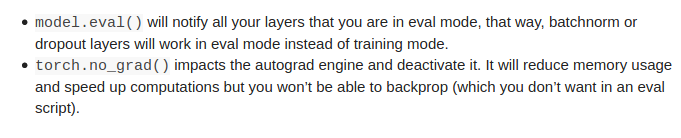

In [36]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data`` 는 학습 및 검증 데이터셋에 대한 dataloader 를 출력합니다.



In [37]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

이제 dataloader를 가져오고 모델을 훈련하는 전체 프로세스를 3 줄의 코드로 실행할 수 있습니다:



In [38]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3184649099707603
1 0.30211381690502165


이러한 기본 3줄의 코드를 사용하여 다양한 모델을 훈련할 수 있습니다.
컨볼루션 신경망(CNN)을 훈련하는 데 사용할 수 있는지 살펴 보겠습니다!

CNN 으로 넘어가기
---------------

이제 3개의 컨볼루션 레이어로 신경망을 구축할 것입니다.
이전 섹션의 어떤 함수도 모델의 형식에 대해 가정하지 않기 때문에,
별도의 수정없이 CNN을 학습하는 데 사용할 수 있습니다.

Pytorch 의 사전정의된
`Conv2d <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`_ 클래스를
컨볼루션 레이어로 사용합니다. 3개의 컨볼루션 레이어로 CNN을 정의합니다.
각 컨볼루션 뒤에는 ReLU가 있습니다. 마지막으로 평균 풀링(average pooling)을 수행합니다.
(``view`` 는 PyTorch의 numpy ``reshape`` 버전입니다.)



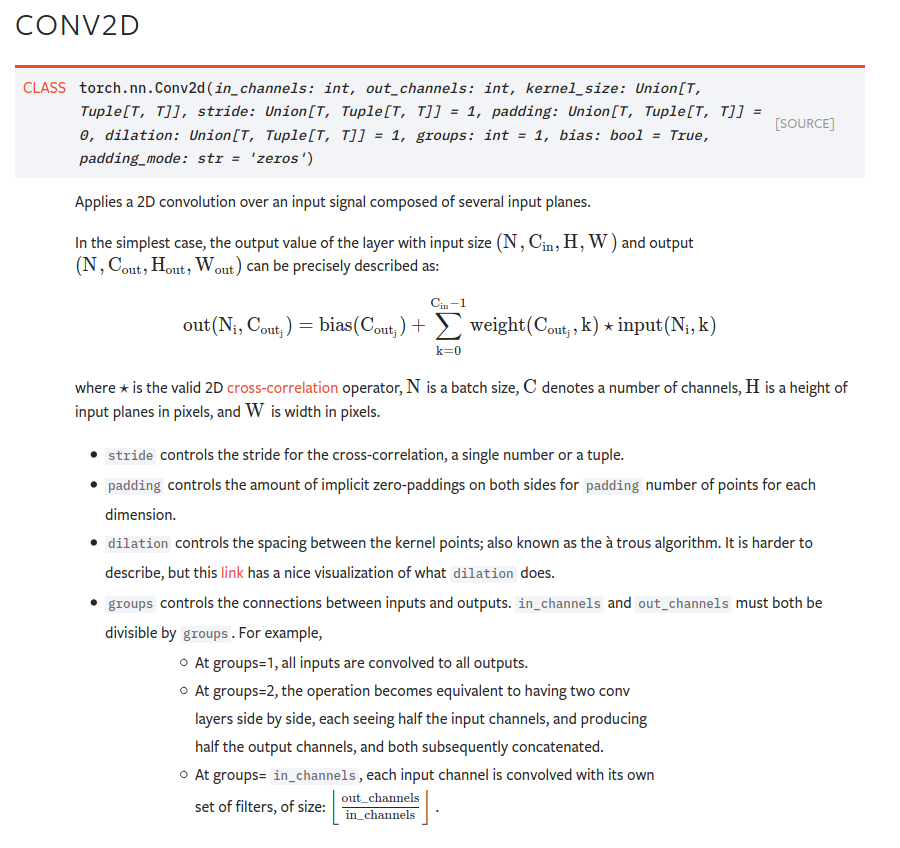

In [75]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

`모멘텀(Momentum) <https://cs231n.github.io/neural-networks-3/#sgd>`_ 은
이전 업데이트도 고려하고 일반적으로 더 빠른 훈련으로 이어지는 확률적 경사하강법(stochastic gradient descent)
의 변형입니다.



In [40]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.32488464159965513
1 0.2368856341958046


nn.Sequential
------------------------

``torch.nn`` 에는 코드를 간단히 사용할 수 있는 또 다른 편리한 클래스인
`Sequential <https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>`_
이 있습니다..
``Sequential`` 객체는 그 안에 포함된 각 모듈을 순차적으로 실행합니다.
이것은 우리의 신경망을 작성하는 더 간단한 방법입니다.

이를 활용하려면 주어진 함수에서 **사용자정의 레이어(custom layer)** 를 쉽게
정의할 수 있어야 합니다.
예를 들어, PyTorch에는 `view` 레이어가 없으므로 우리의 신경망 용으로 만들어야 합니다.
``Lambda`` 는 ``Sequential`` 로 신경망을 정의할 때 사용할 수 있는 레이어를 생성할 것입니다.



In [41]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

``Sequential`` 로 생성된 모들은 간단하게 아래와 같습니다:



In [42]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3622327014923096
1 0.2877293968200684


DataLoader 감싸기
-----------------------------

우리의 CNN은 상당히 간결하지만, MNIST에서만 작동합니다, 왜냐하면:
 - 입력이 28\*28의 긴 벡터라고 가정합니다.
 - 최종적으로 CNN 그리드 크기는 4\*4 라고 가정합니다. (이것은 우리가 사용한 평균 풀링 커널 크기 때문입니다.)

이 두 가지 가정을 제거하여 모델이 모든 2d 단일 채널(channel) 이미지에서 작동하도록 하겠습니다.
먼저 초기 Lambda 레이어를 제거하고 데이터 전처리를 제네레이터(generator)로 이동시킬 수 있습니다:



In [43]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

다음으로 ``nn.AvgPool2d`` 를 ``nn.AdaptiveAvgPool2d`` 로 대체하여 우리가 가진
*입력* 텐서가 아니라 원하는 *출력* 텐서의 크기를 정의할 수 있습니다.
결과적으로 우리 모델은 모든 크기의 입력과 함께 작동합니다.



In [44]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

한번 실행해 봅시다:



In [45]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33722894755601884
1 0.23781599349975585


GPU 사용하기
---------------

만약 여러분들이 운이 좋아서 CUDA 지원 GPU (대부분의 클라우드 제공 업체에서
시간당 약 $0.50 에 이용할 수 있습니다) 를 사용할 수 있다면, 코드 실행 속도를 높일 수 있습니다.
먼저 GPU가 Pytorch에서 작동하는지 확인합니다:



In [46]:
print(torch.cuda.is_available())

False


그리고 이에 대한 디바이스 오브젝트를 생성합니다:



In [47]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

GPU로 배치를 옮기도록 ``preprocess`` 를 업데이트 합시다:



In [48]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

마지막으로 모델을 GPU로 이동시킬 수 있습니다.



In [49]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

이제 더 빨리 실행됩니다:



In [50]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.20050445054769517
1 0.2037589302957058


마치면서
-----------------

이제 Pytorch를 사용하여 다양한 유형의 모델을 학습하는 데 사용할 수 있는 일반 데이터 파이프 라인과
훈련 루프가 있습니다.
이제 모델 학습이 얼마나 간단한지 확인하려면 `mnist_sample` 샘플 노트북을 살펴보세요.

물론 데이터 증강(data augmentation), 초매개변수 조정(hyperparameter tuning),
훈련과정 모니터링(monitoring training), 전이 학습(transfer learning) 등과 같이
추가하고 싶은 항목들이 많이 있을 것입니다.
이러한 기능들은 이 튜토리얼에 표시된 것과 동일한 설계 접근 방식을 사용하여 개발된 fastai 라이브러리에서
사용할 수 있으며, 모델을 더욱 발전시키려는 실무자에게 자연스러운 다음 단계를 제공합니다.

이 튜토리얼의 시작 부분에서 ``torch.nn``, ``torch.optim``, ``Dataset``,
그리고 ``DataLoader`` 의 각 예제를 통해 설명하겠다고 이야기했었습니다.
이제 위의 내용들을 요약해보겠습니다:

 - **torch.nn**

   + ``Module``: 함수처럼 동작하지만, 또한 상태(state) (예를 들어, 신경망의 레이어 가중치)를
     포함할 수 있는 호출 가능한 오브젝트를 생성합니다.
     이는 포함된 ``Parameter`` (들)가 어떤 것인지 알고, 모든 기울기를 0으로 설정하고 가중치
     업데이트 등을 위해 반복할 수 있습니다.
   + ``Parameter``: ``Module`` 에 역전파 동안 업데이트가 필요한 가중치가 있음을 알려주는
     텐서용 래퍼입니다. `requires_grad` 속성이 설정된 텐서만 업데이트 됩니다.
   + ``functional``: 활성화 함수, 손실 함수 등을 포함하는 모듈 (관례에 따라 일반적으로
     ``F`` 네임스페이스로 임포트 됩니다) 이고, 물론 컨볼루션 및 선형 레이어 등에 대해서
     상태를 저장하지않는(non-stateful) 버전의 레이어를 포함합니다.
 - ``torch.optim``: 역전파 단계에서 ``Parameter`` 의 가중치를 업데이트하는,
   ``SGD`` 와 같은 옵티마이저를 포함합니다.
 - ``Dataset``: ``TensorDataset`` 과 같이 Pytorch와 함께 제공되는 클래스를 포함하여 ``__len__`` 및
   ``__getitem__`` 이 있는 객체의 추상 인터페이스
 - ``DataLoader``: 모든 종류의 ``Dataset`` 을 기반으로 데이터의 배치들을 출력하는 반복자(iterator)를 생성합니다.

